In [71]:
import math
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum as qsum
import time
import routing
from routing import VRPInstance, VRPModel
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from heapq import heappush, heappop

In [72]:
num_customers = 20
data_df = pd.read_csv('data.dat', sep='\s+')
data_dict_rows = data_df.to_dict(orient='records')
locations = {row['CUST_NO'] : row for row in data_dict_rows if row['CUST_NO'] <= num_customers}
depot = 1
cost_per_mile = 1
avg_speed = 1 # miles per hour
n = len(locations)

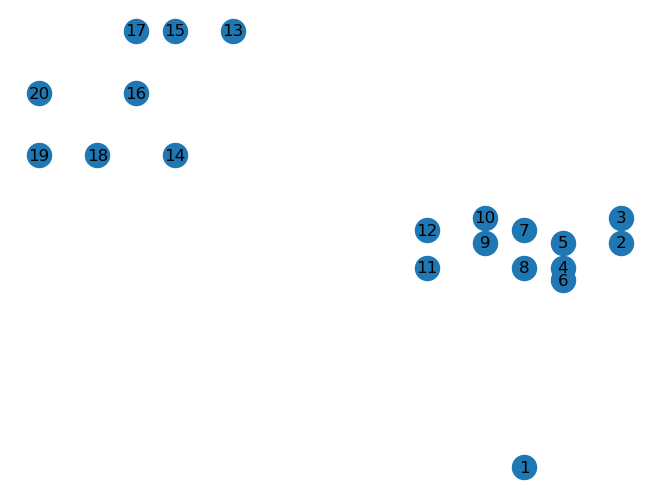

In [73]:
routing.show_tours([], locations, to_tikz=True, tikz_file_name='customers.tex')

Create dictionaries to hold problem data.

In [74]:
nodes = list(locations.keys())
edges = [(i,j) for i in nodes for j in nodes if i != j]
dist = {}
edge_costs = {}
travel_time = {}
for i in nodes:
    for j in nodes:
        x = routing.get_coordinate(locations, i)
        y = routing.get_coordinate(locations, j)
        dist[(i, j)] = routing.euclidean_distance(x, y)
        edge_costs[(i, j)] = routing.get_cost(x, y, cost_per_mile)
        travel_time[(i, j)] = routing.get_time(x, y, avg_speed)

# TSP

In [75]:
m = routing.create_tsp_model(depot, nodes, edge_costs)
routing.solve_model(m)

Optimal objective value: 116
Optimization time: 0.907 seconds


In [76]:
edges_used_gurobi = [(i, j) for i, j in edges if m._x[i, j].x > 0.5]
tour = routing.get_tour_from_edges_used(edges_used_gurobi)
print("complete tour", tour)
print("cost", routing.get_cost_of_tour(tour, edge_costs))
# for i in tour[:-1]:
#     print("Node", i, "visited at time", m._u[i].x)

complete tour [1, 11, 12, 14, 18, 19, 20, 16, 17, 15, 13, 10, 9, 7, 5, 3, 2, 4, 6, 8, 1]
cost 116


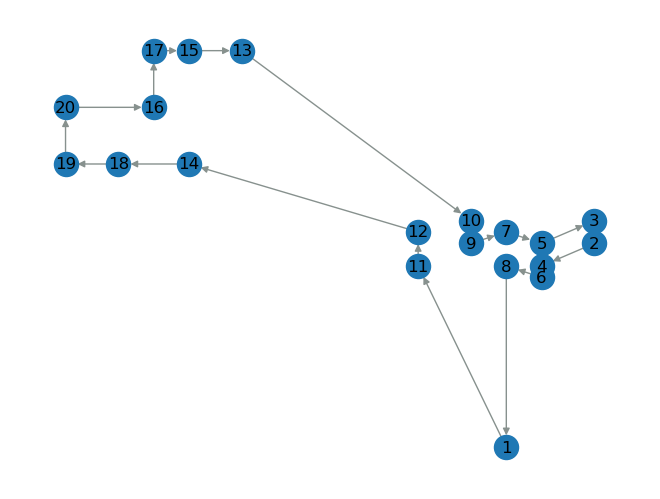

In [77]:
routing.show_tours([edges_used_gurobi], locations, to_tikz = True, tikz_file_name = "tsp.tex")

# TSP Relaxation

In [78]:
m = routing.create_tsp_model(depot, nodes, edge_costs, relaxed=True)
routing.solve_model(m)
edges_used_adjacency_list= {i : {j : m._x[i, j].x for j in nodes} for i in nodes}
for i in edges_used_adjacency_list:
    for j in edges_used_adjacency_list[i]:
        if edges_used_adjacency_list[i][j] > 0.01:
            print((i,j), edges_used_adjacency_list[i][j])

Optimal objective value: 85
Optimization time: 0.002 seconds
(1, 8) 0.95
(1, 11) 0.050000000000000044
(2, 3) 0.95
(2, 5) 0.04999999999999993
(3, 2) 0.95
(3, 5) 0.04999999999999993
(4, 6) 1.0
(5, 2) 0.04999999999999993
(5, 3) 0.04999999999999993
(5, 7) 0.9000000000000001
(6, 1) 0.04999999999999999
(6, 4) 0.9
(6, 8) 0.04999999999999999
(7, 5) 0.9000000000000002
(7, 10) 0.09999999999999976
(8, 1) 0.9
(8, 4) 0.09999999999999998
(9, 7) 0.04999999999999993
(9, 10) 0.9000000000000002
(9, 12) 0.04999999999999982
(10, 7) 0.04999999999999993
(10, 9) 0.95
(11, 1) 0.04999999999999982
(11, 12) 0.9500000000000002
(12, 9) 0.050000000000000155
(12, 11) 0.9499999999999998
(13, 15) 0.04999999999999993
(13, 17) 0.9500000000000001
(14, 16) 0.9500000000000001
(14, 18) 0.04999999999999993
(15, 13) 0.95
(15, 17) 0.04999999999999993
(16, 14) 0.04999999999999993
(16, 20) 0.9500000000000001
(17, 13) 0.04999999999999993
(17, 15) 0.9500000000000001
(18, 14) 0.9500000000000001
(18, 19) 0.04999999999999993
(19, 18)

In [79]:
rounded_tour = routing.round_tsp_solution(edges_used_adjacency_list, n)
print("rounded_tour", rounded_tour)
complete_rounded = routing.complete_tour(rounded_tour)
print("cost", routing.get_cost_of_tour(complete_rounded, 
                                       edge_costs))

1 {8: 0.95, 11: 0.050000000000000044}
8 {4: 0.09999999999999998}
4 {6: 1.0}
6 {}
2 {3: 0.95, 5: 0.04999999999999993}
3 {5: 0.04999999999999993}
5 {7: 0.9000000000000001}
7 {10: 0.09999999999999976}
10 {9: 0.95}
9 {12: 0.04999999999999982}
12 {11: 0.9499999999999998}
11 {}
13 {15: 0.04999999999999993, 17: 0.9500000000000001}
17 {15: 0.9500000000000001}
15 {}
14 {16: 0.9500000000000001, 18: 0.04999999999999993}
16 {20: 0.9500000000000001}
20 {19: 0.9500000000000001}
19 {18: 0.95}
rounded_tour [1, 8, 4, 6, 2, 3, 5, 7, 10, 9, 12, 11, 13, 17, 15, 14, 16, 20, 19, 18]
cost 132


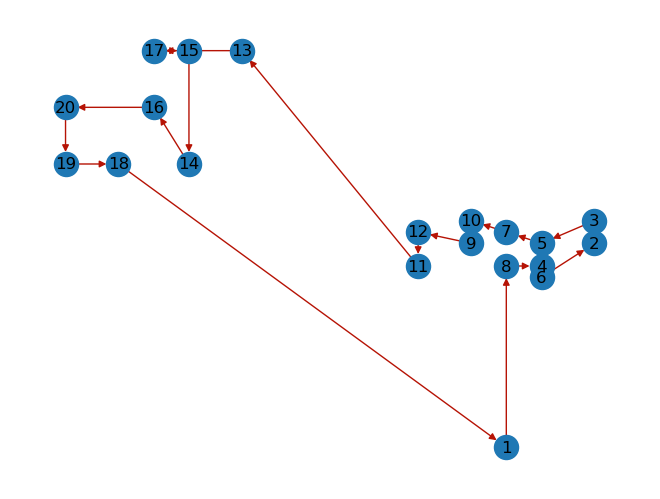

In [80]:
edges_used_rounded = routing.get_edges_used_from_tour(complete_rounded)
routing.show_tours([edges_used_rounded], locations, to_tikz = True, 
                   tikz_file_name = "tsp_rounded.tex")

# TSP Model: Subtour Elimination Constraints

Optimal objective value: 85
Optimization time: 0.004 seconds


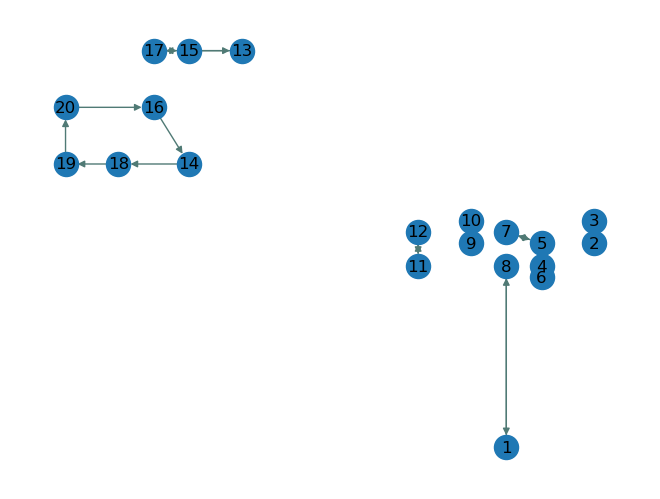

minimal subtours [[3, 2], [6, 4], [7, 5], [8, 1], [10, 9], [12, 11]]


In [81]:
m = routing.create_tsp_model_subtour_elim(nodes, edge_costs)
m.write("tsp-subtour-elim.lp")
routing.solve_model(m)

edges_used_gurobi = [(i, j) for i, j in edges if m._x[i, j].x > 0.5]

routing.show_tours([edges_used_gurobi], locations, to_tikz = True, tikz_file_name = "tsp.tex")

print("minimal subtours", routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi))

Optimal objective value: 89
Optimization time: 0.007 seconds


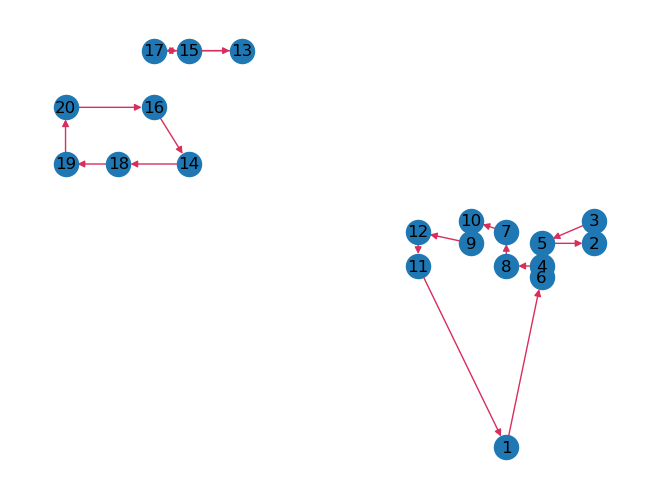

minimal subtours [[5, 2, 3], [17, 15, 13]]


In [82]:
for subset in routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi):
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used_gurobi = [(i, j) for i, j in edges if m._x[i, j].x > 0.5]

routing.show_tours([edges_used_gurobi], locations, to_tikz = True, tikz_file_name = "tsp.tex")

print("minimal subtours", routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi))

Optimal objective value: 92
Optimization time: 0.004 seconds


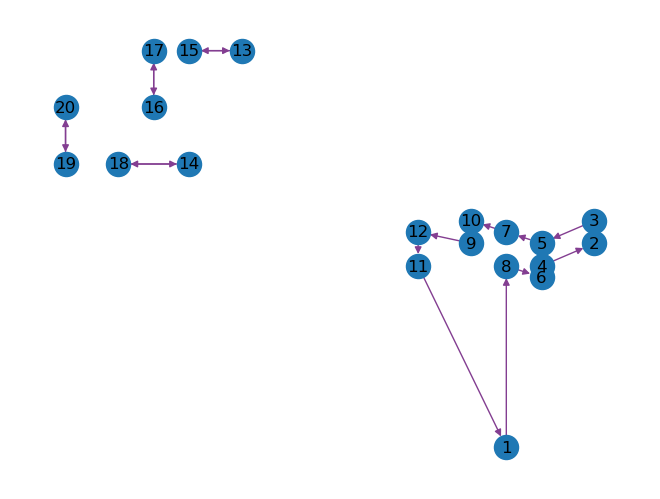

minimal subtours [[15, 13], [17, 16], [18, 14], [20, 19]]


In [83]:
for subset in routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi):
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used_gurobi = [(i, j) for i, j in edges if m._x[i, j].x > 0.5]

routing.show_tours([edges_used_gurobi], locations, to_tikz = True, tikz_file_name = "tsp.tex")

print("minimal subtours", routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi))

Optimal objective value: 94
Optimization time: 0.004 seconds


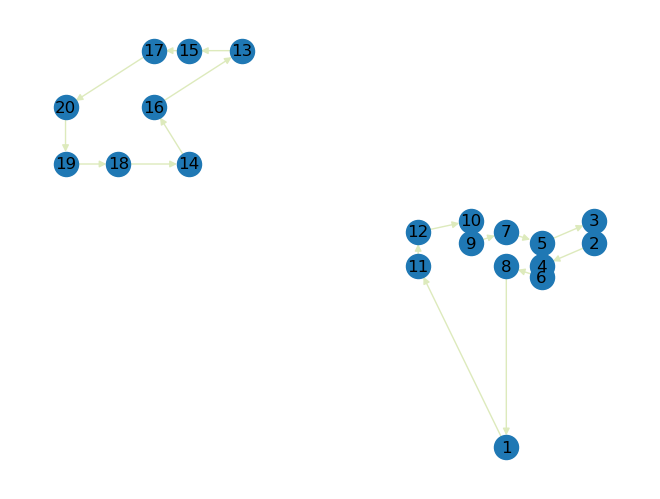

minimal subtours [[20, 19, 18, 14, 16, 13, 15, 17]]


In [84]:
for subset in routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi):
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used_gurobi = [(i, j) for i, j in edges if m._x[i, j].x > 0.5]

routing.show_tours([edges_used_gurobi], locations, to_tikz = True, tikz_file_name = "tsp.tex")

print("minimal subtours", routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi))

Optimal objective value: 114
Optimization time: 0.004 seconds


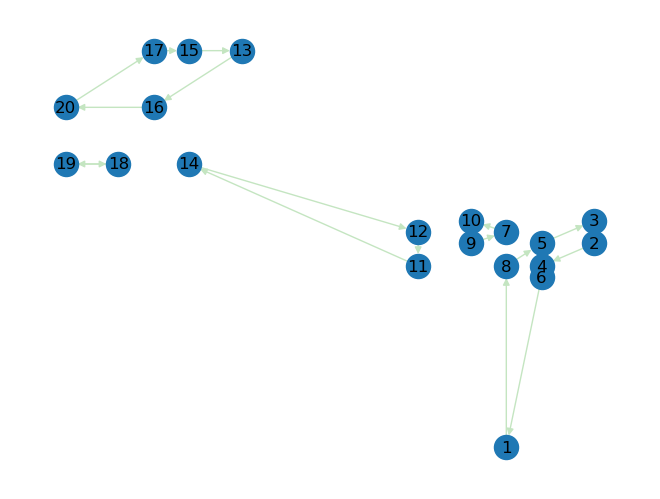

minimal subtours [[19, 18]]


In [85]:
for subset in routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi):
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used_gurobi = [(i, j) for i, j in edges if m._x[i, j].x > 0.5]

routing.show_tours([edges_used_gurobi], locations, to_tikz = False)

print("minimal subtours", routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi))

Optimal objective value: 115
Optimization time: 0.004 seconds


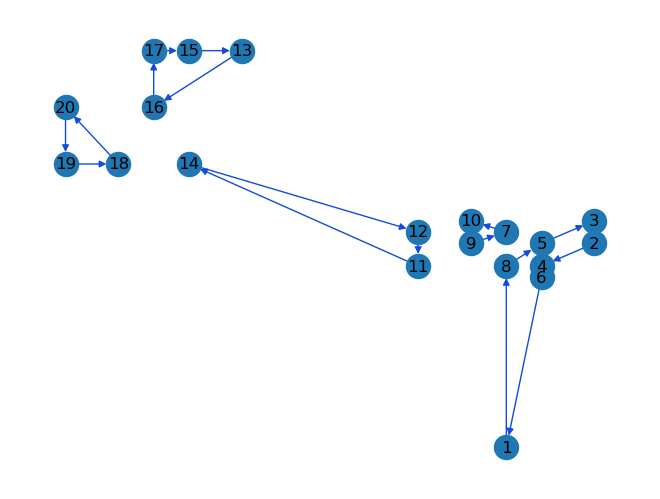

minimal subtours [[10, 9, 7], [14, 12, 11], [20, 19, 18]]


In [86]:
for subset in routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi):
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used_gurobi = [(i, j) for i, j in edges if m._x[i, j].x > 0.5]

routing.show_tours([edges_used_gurobi], locations, to_tikz = False)

print("minimal subtours", routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi))

Optimal objective value: 115
Optimization time: 0.004 seconds


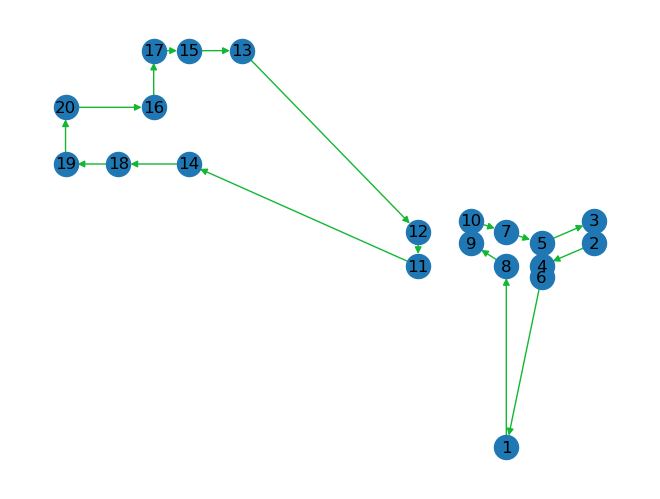

minimal subtours [[10, 7, 5, 3, 2, 4, 6, 1, 8, 9], [20, 16, 17, 15, 13, 12, 11, 14, 18, 19]]


In [87]:
for subset in routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi):
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used_gurobi = [(i, j) for i, j in edges if m._x[i, j].x > 0.5]

routing.show_tours([edges_used_gurobi], locations, to_tikz = False)

print("minimal subtours", routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi))

Optimal objective value: 115
Optimization time: 0.005 seconds


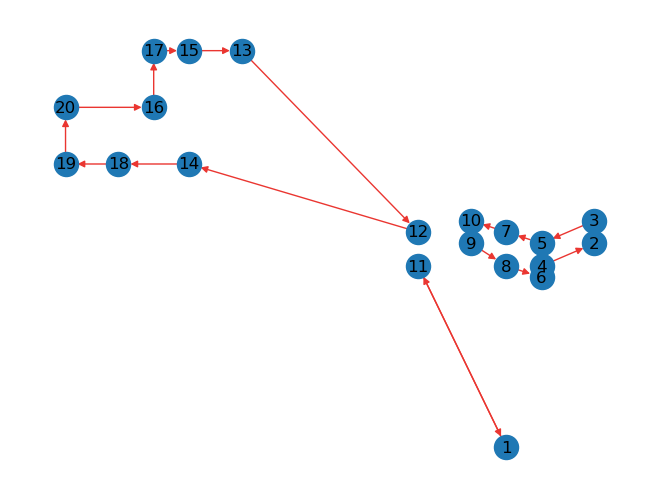

minimal subtours [[11, 1]]


In [88]:
for subset in routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi):
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used_gurobi = [(i, j) for i, j in edges if m._x[i, j].x > 0.5]

routing.show_tours([edges_used_gurobi], locations, to_tikz = False)

print("minimal subtours", routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi))

Optimal objective value: 115
Optimization time: 0.005 seconds


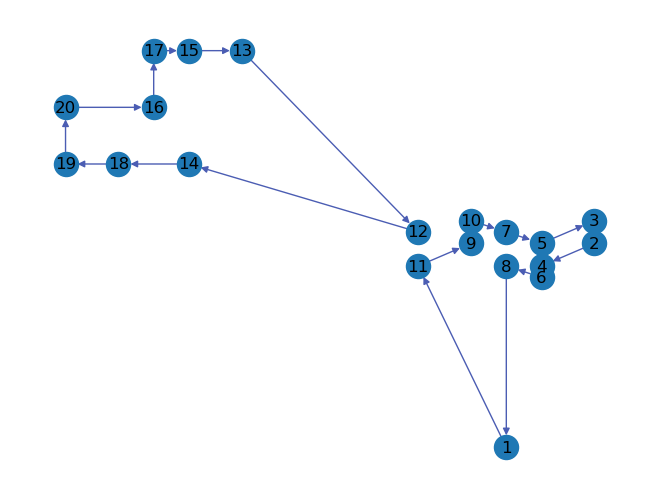

minimal subtours [[20, 16, 17, 15, 13, 12, 14, 18, 19]]


In [89]:
for subset in routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi):
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used_gurobi = [(i, j) for i, j in edges if m._x[i, j].x > 0.5]

routing.show_tours([edges_used_gurobi], locations, to_tikz = False)

print("minimal subtours", routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi))

Optimal objective value: 116
Optimization time: 0.005 seconds


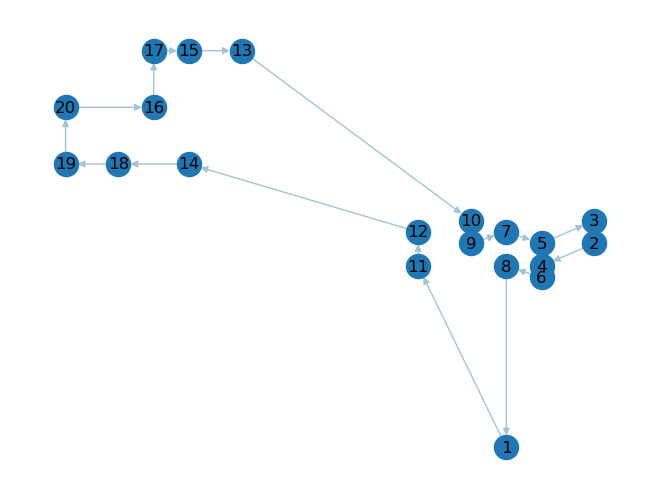

minimal subtours [[20, 16, 17, 15, 13, 10, 9, 7, 5, 3, 2, 4, 6, 8, 1, 11, 12, 14, 18, 19]]


In [90]:
for subset in routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi):
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used_gurobi = [(i, j) for i, j in edges if m._x[i, j].x > 0.5]

routing.show_tours([edges_used_gurobi], locations, to_tikz = False)

print("minimal subtours", routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi))

In [91]:
# for subset in routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi):
#     m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

# routing.solve_model(m)

# edges_used_gurobi = [(i, j) for i, j in edges if m._x[i, j].x > 0.5]

# routing.show_tours([edges_used_gurobi], locations, to_tikz = False)

# print("minimal subtours", routing.get_minimal_cycles_in_directed_graph(edges_used_gurobi))

# TSP Model: Subtour Elimination Constraints (Relaxation)

Optimal objective value: 85
Optimization time: 0.001 seconds


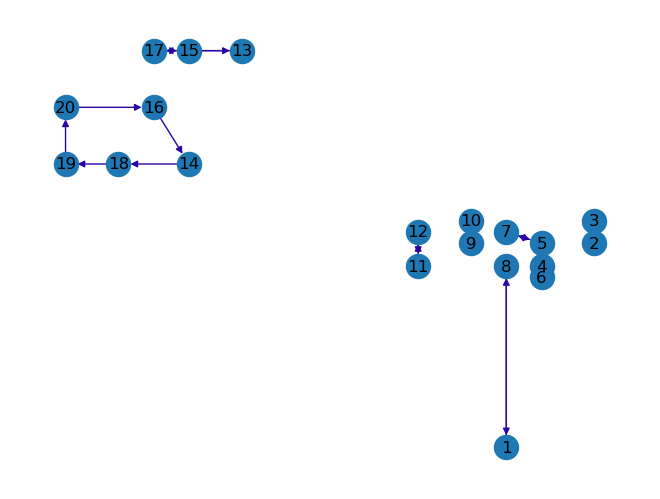

In [92]:
m = routing.create_tsp_model_subtour_elim(nodes, edge_costs, relaxed=True)
routing.solve_model(m)

edges_used_gurobi = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
            
routing.show_tours([edges_used_gurobi], locations, to_tikz = False)

all integer
minimal cycles [[3, 2], [6, 4], [7, 5], [8, 1], [10, 9], [12, 11]]
Optimal objective value: 89
Optimization time: 0.001 seconds


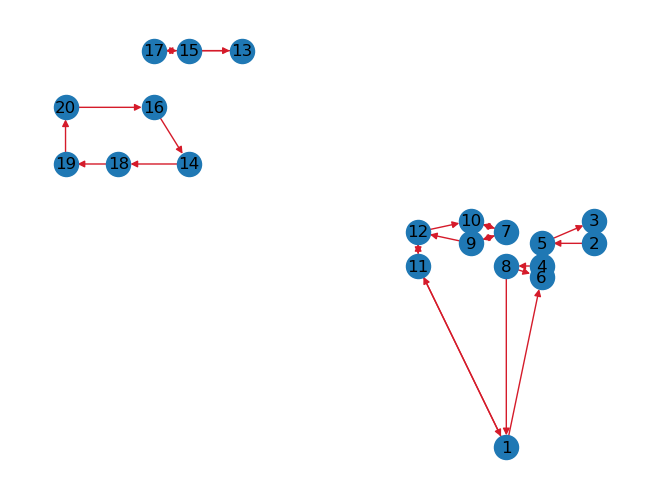

In [93]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

# print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
for subset in minimal_cycles:
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]

routing.show_tours([edges_used], locations, to_tikz = False)

not integer
1 6 0.5
1 11 0.5
7 9 0.5
7 10 0.5
8 1 0.5
8 6 0.5
9 7 0.5
9 12 0.5
10 7 0.5
10 9 0.5
11 1 0.5
11 12 0.5
12 10 0.5
12 11 0.5
minimal cycles [[5, 3, 2], [17, 15, 13]]
Optimal objective value: 92
Optimization time: 0.0 seconds


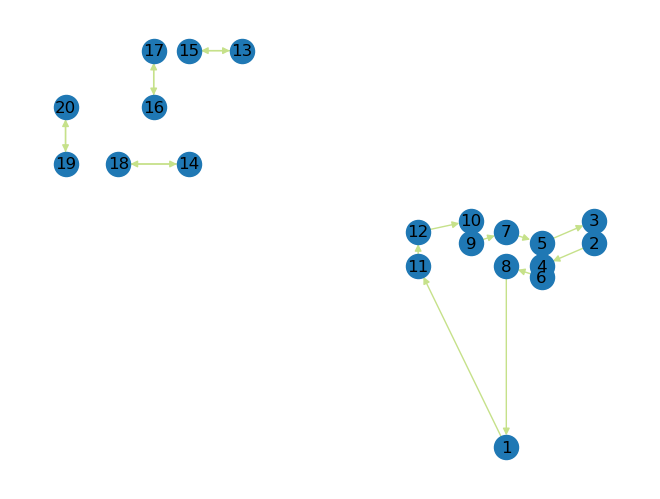

In [94]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

#print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
for subset in minimal_cycles:
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]

routing.show_tours([edges_used], locations, to_tikz = False)

all integer
minimal cycles [[15, 13], [17, 16], [18, 14], [20, 19]]
Optimal objective value: 94
Optimization time: 0.0 seconds


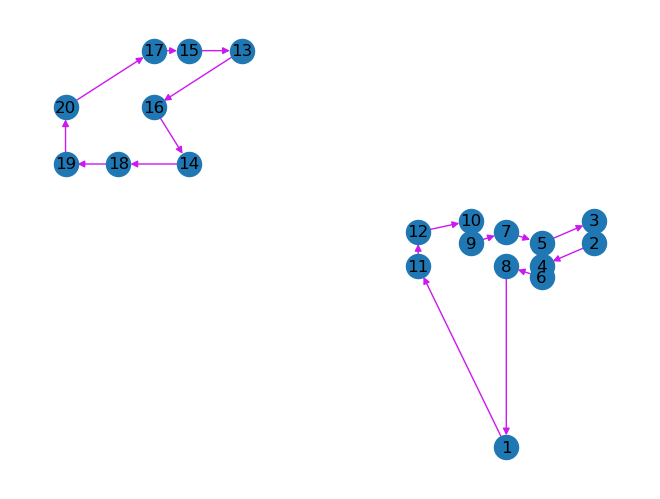

In [95]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

#print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
for subset in minimal_cycles:
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]

routing.show_tours([edges_used], locations, to_tikz = False)

all integer
minimal cycles [[20, 17, 15, 13, 16, 14, 18, 19]]
Optimal objective value: 114
Optimization time: 0.001 seconds


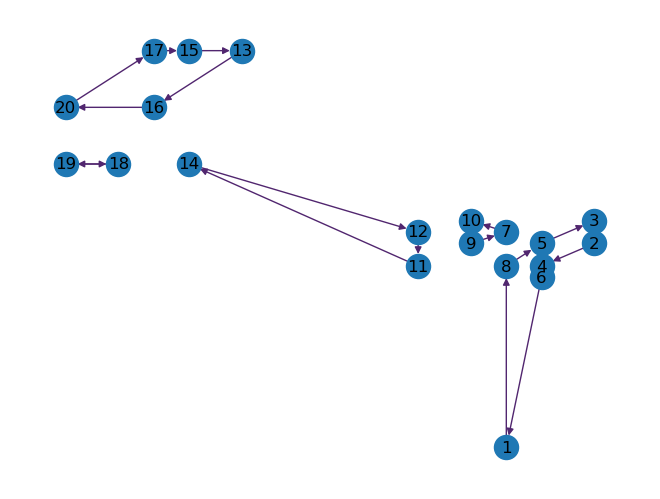

In [96]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

#print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
for subset in minimal_cycles:
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]

routing.show_tours([edges_used], locations, to_tikz = False)

all integer
minimal cycles [[19, 18]]
Optimal objective value: 115
Optimization time: 0.0 seconds


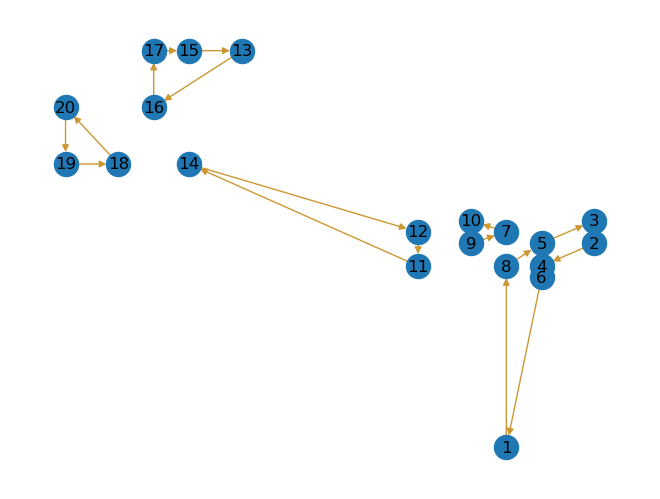

In [97]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

#print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
for subset in minimal_cycles:
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]

routing.show_tours([edges_used], locations, to_tikz = False)

all integer
minimal cycles [[10, 9, 7], [14, 12, 11], [20, 19, 18]]
Optimal objective value: 115
Optimization time: 0.0 seconds


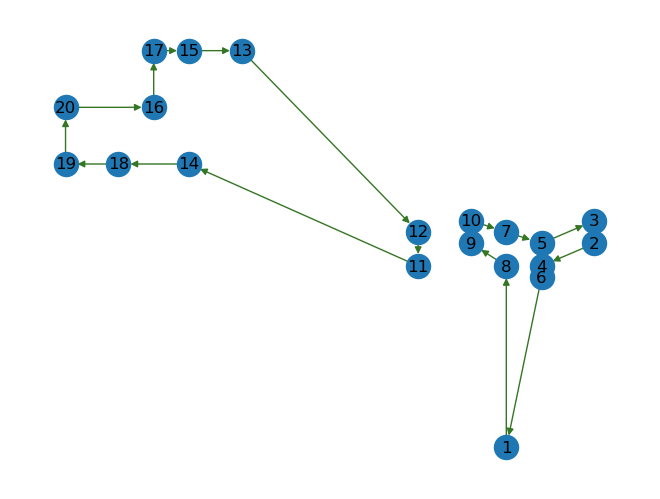

In [98]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

#print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
for subset in minimal_cycles:
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]

routing.show_tours([edges_used], locations, to_tikz = False)

all integer
minimal cycles [[10, 7, 5, 3, 2, 4, 6, 1, 8, 9], [20, 16, 17, 15, 13, 12, 11, 14, 18, 19]]
Optimal objective value: 115
Optimization time: 0.0 seconds


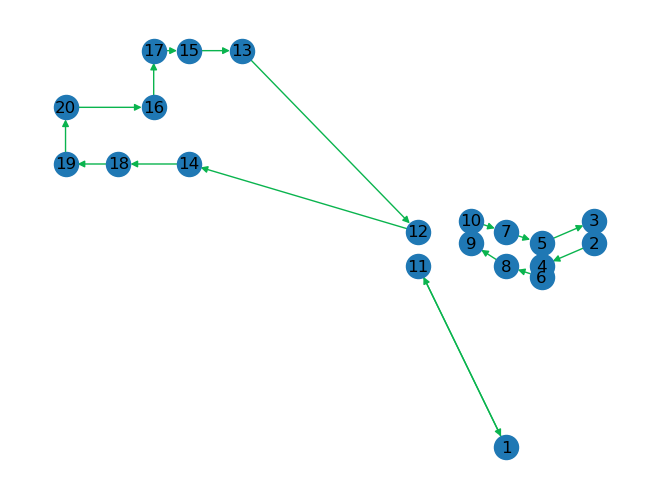

In [99]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

#print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
for subset in minimal_cycles:
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]

routing.show_tours([edges_used], locations, to_tikz = False)

all integer
minimal cycles [[11, 1]]
Optimal objective value: 115
Optimization time: 0.001 seconds


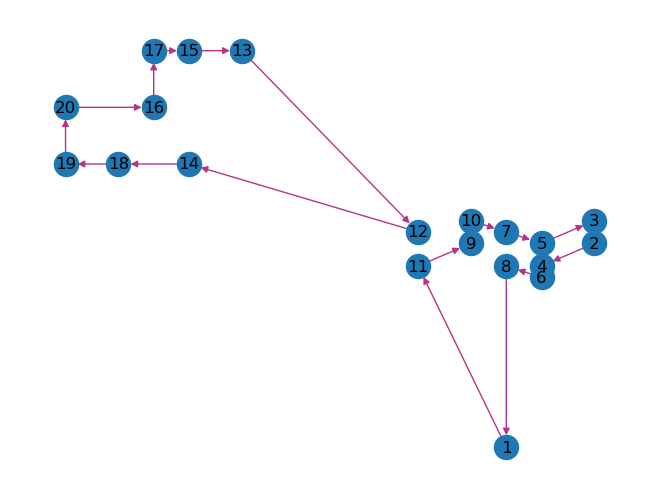

In [100]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

#print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
for subset in minimal_cycles:
    m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)

routing.solve_model(m)

edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]

routing.show_tours([edges_used], locations, to_tikz = False)

all integer
minimal cycles [[20, 16, 17, 15, 13, 12, 14, 18, 19]]
Optimal objective value: 116
Optimization time: 0.0 seconds


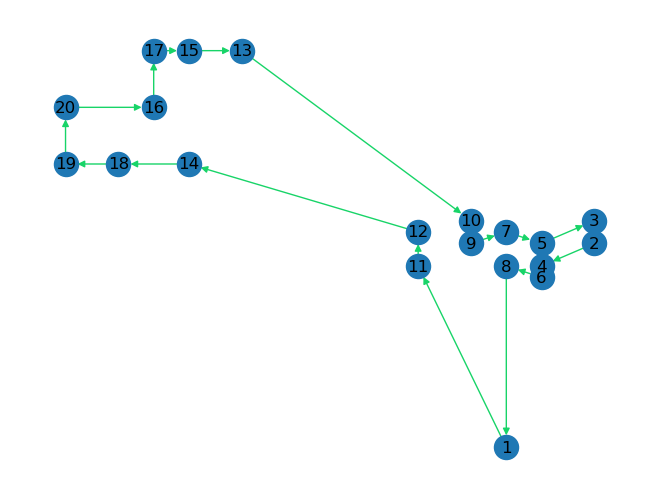

In [101]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")
    edges_used_integer = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
else:
    print("not integer")
    for i, j in edges:
        if m._x[i, j].x >= 0.001 and m._x[i, j].x <= 0.999:
            print(i, j, m._x[i, j].x)
    edges_used_integer = [(i, j) for i, j in edges if (1 - m._x[i, j].x) <= 0.001]

#print("edges_used_integer", edges_used_integer)

minimal_cycles = routing.get_minimal_cycles_in_directed_graph(edges_used_integer)
print("minimal cycles", minimal_cycles)
if len(minimal_cycles) < n:
    for subset in minimal_cycles:
        m.addConstr(qsum(m._x[i, j] for i in subset for j in subset if i != j) <= len(subset) - 1)
        routing.solve_model(m)
        edges_used = [(i, j) for i, j in edges if m._x[i, j].x > 0.001]
        routing.show_tours([edges_used], locations, to_tikz = False)
else:
    print("done")

In [102]:
if all(min(m._x[i, j].x, 1 - m._x[i, j].x) <= 0.001 for i, j in edges):
    print("all integer")

all integer


# VRP with Time Windows (VRPTW)

In [103]:
num_vehicles  = 3
num_customers = 10
vehicle_capacity = 50

In [104]:
instance = VRPInstance(data_file = 'data.dat', 
                    num_customers = num_customers,
                    num_vehicles = num_vehicles, 
                    depot = 1, 
                    vehicle_capacity = vehicle_capacity,
                    average_speed=1,
                    cost_per_mile=1)
vrptw = VRPModel(instance)
m = vrptw.get_gurobipy_model()
m.write("vrptw.lp")
routing.solve_model(m)

Optimal objective value: 118
Optimization time: 0.027 seconds


In [105]:
#print("nodes", instance.nodes)
edges_used_list = []
for k in instance.vehicles:
    print("vehicle", k)
    edges_used_gurobi_vrptw = [(i, j) for i, j in instance.edges if m._x[i, j, k].x > 0.5]
    edges_used_list.append(edges_used_gurobi_vrptw)
    #print("edges used", edges_used_gurobi_vrptw)
    if len(edges_used_gurobi_vrptw) > 0:
        tour_vrptw = routing.get_tour_from_edges_used(edges_used_gurobi_vrptw)
        print("tour", tour_vrptw)
        # for i in tour_vrptw[:-1]:
        #     print("Node", i, "visited at time", m._t[i,k].x)
        # print("return time", m._return_time[k].x)

vehicle 0
tour [1, 9, 10, 7, 1]
vehicle 1
tour [1, 5, 3, 2, 1]
vehicle 2
tour [1, 6, 4, 8, 1]


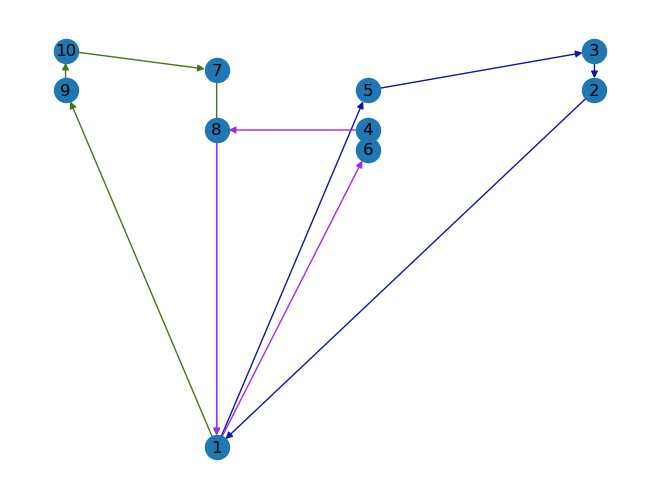

In [106]:
routing.show_tours(edges_used_list, instance.locations, to_tikz = True,
                   num_vehicles = num_vehicles,
                   tikz_file_name = "vrptw.tex")

# VRPTW: Relaxation

In [107]:
instance = VRPInstance(data_file = 'data.dat', 
                    num_customers = num_customers,
                    num_vehicles = num_vehicles, 
                    depot = 1, 
                    vehicle_capacity = vehicle_capacity,
                    average_speed=1,
                    cost_per_mile=1)
vrptw = VRPModel(instance)
m = vrptw.get_gurobipy_model(relaxed = True)
routing.solve_model(m)

Optimal objective value: 107
Optimization time: 0.003 seconds


In [108]:
for k in instance.vehicles:
    print("vehicle", k)
    edges_used_adjacency_list= {i : {j : m._x[i, j,k].x for j in instance.nodes} for i in instance.nodes}
    for i in edges_used_adjacency_list:
        for j in edges_used_adjacency_list[i]:
            if edges_used_adjacency_list[i][j] > 0.01:
                print((i,j), edges_used_adjacency_list[i][j])

vehicle 0
(1, 6) 0.9999998672540497
(2, 3) 0.24987042705098295
(3, 2) 0.24987042705098295
(5, 7) 0.9998017639320225
(6, 1) 0.9999998672540495
(7, 5) 0.9998017639320225
vehicle 1
(1, 4) 0.9994817082039322
(4, 1) 0.9994817082039322
(9, 10) 0.999629
(10, 9) 0.999629
vehicle 2
(1, 8) 0.9994817082039322
(2, 3) 0.750129572949017
(3, 2) 0.750129572949017
(8, 1) 0.9994817082039322
